# Movie Data Analysis #

In [1]:
########################import libraries####################
import pandas as pd
import numpy as np
import csv
import pickle
import glob
from pyspark.sql import SQLContext,SparkSession
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from dataframe_sql import register_temp_table, query
import findspark
import pyspark.sql.functions as f
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.style.use("seaborn-pastel")
plt.show()
findspark.init()

# Question 1: Movies made each year#

## Strategy to Solve the problem ## 

1. Using Spark Session and pushing filtered data into the temporary tables & solving the problem.
2. Using basic python functionality to check whether we receive the correct counts.

### Using Spark-SQL to solve the problem ###

In [2]:
###############Creating Spark Session#########################
sc = SparkSession.builder.appName("PySparkExample")\
    .config ("spark.sql.shuffle.partitions", "50") \
    .config("spark.driver.maxResultSize","5g") \
    .config ("spark.sql.execution.arrow.enabled", "true")\
    .getOrCreate()

In [3]:
###############Function to create temporary table#################
def create_temp_table(data1,data2):
    data1.repartition(10).rdd.getNumPartitions()
    data1.createOrReplaceTempView(data2)   

In [4]:
###################Read data using spark session#######################
filepath_title_data='Documents/Movies/title.basics.tsv' #Change filepath for title_data
filepath_basic_data='Documents/Movies/name.basics.tsv' #Change filepath for basic_data
filepath_crew_data='Documents/Movies/title.crew.tsv' #Change filepath for crew_data
filepath_out_data='Documents/Movies/out'

Title_data = sc.read.csv(filepath_title_data+"/data.tsv",sep="\t",header= True)
Title_data.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [5]:
#############Create temp table for Title_data##################
create_temp_table(Title_data,"Title_data")

In [6]:
###################Movies made each year#####################
Title_by_year = sc.sql("SELECT startYear,count(startYear) as MOVIE_COUNT from Title_data where startYear IS NOT NULL and titleType like '%movie%' and titleType IS NOT NULL and primaryTitle IS NOT NULL and originalTitle IS NOT NULL GROUP BY startYear ORDER BY count(startYear) desc")
Title_by_year.show()

+---------+-----------+
|startYear|MOVIE_COUNT|
+---------+-----------+
|       \N|      72681|
|     2017|      17943|
|     2018|      17771|
|     2016|      17582|
|     2019|      17121|
|     2015|      16403|
|     2014|      15849|
|     2013|      14771|
|     2020|      14569|
|     2012|      14087|
|     2011|      13144|
|     2010|      12207|
|     2009|      11443|
|     2021|      10813|
|     2008|       9983|
|     2007|       8533|
|     2006|       7820|
|     2005|       7363|
|     2004|       6392|
|     2003|       5870|
+---------+-----------+
only showing top 20 rows



In [7]:
###########Test case 1: To Verify movie data count for 2017#################
Title_data_movie = sc.sql("SELECT * from Title_data where startYear IS NOT NULL and titleType like '%movie%' and startYear='2017'")

Title_data_movie.count()

17943

In [8]:
#############Create temp table for Title_data##################
create_temp_table(Title_by_year,"Title_by_year")

##################Distribution over past 100 years###################
Title_by_year_filtered = sc.sql("SELECT * from Title_by_year where startYear between '1922' and '2021'")
Title_by_year_filtered.show()

+---------+-----------+
|startYear|MOVIE_COUNT|
+---------+-----------+
|     2017|      17943|
|     2018|      17771|
|     2016|      17582|
|     2019|      17121|
|     2015|      16403|
|     2014|      15849|
|     2013|      14771|
|     2020|      14569|
|     2012|      14087|
|     2011|      13144|
|     2010|      12207|
|     2009|      11443|
|     2021|      10813|
|     2008|       9983|
|     2007|       8533|
|     2006|       7820|
|     2005|       7363|
|     2004|       6392|
|     2003|       5870|
|     2002|       5677|
+---------+-----------+
only showing top 20 rows



In [9]:
#################Test case 2: Check for 100 years###########
Title_by_year_filtered.count()

100

## Using python functionalities to verify data counts ##

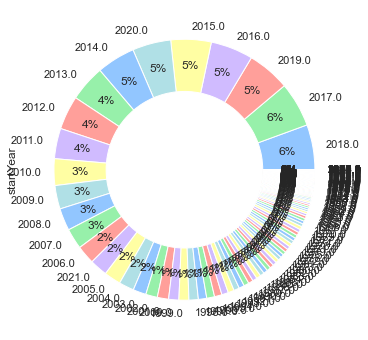

In [10]:
###############Reading data and excluding escape & NA values##################
df_title_=pd.read_csv(filepath_title_data+"/data.tsv",sep="\t",low_memory=False, na_values=["\\N","nan"])

###############Value counts & percentage of StartYear distribution############
df_title_.startYear.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                                 wedgeprops=dict(width=0.4))


In [12]:
################Value counts are without movies filtered#############
df_title_.startYear.value_counts()

2018.0    396089
2017.0    393908
2019.0    376047
2016.0    373422
2015.0    354834
           ...  
1877.0         1
1885.0         1
1874.0         1
1881.0         1
1883.0         1
Name: startYear, Length: 148, dtype: int64

In [12]:
##############Filter dataframe by movie data####################
M_data=(df_title_['titleType']=='movie')

In [13]:
###################Test Case 3: Verifying counts##################
Movie_data_1 =df_title_.loc[df_title_['titleType']=='movie']
Movie_data_1.startYear.value_counts()

2017.0    17943
2018.0    17771
2016.0    17582
2019.0    17121
2015.0    16403
          ...  
2028.0        3
2026.0        3
1904.0        2
1897.0        1
1896.0        1
Name: startYear, Length: 133, dtype: int64

In [14]:
gk_result=Movie_data_1.groupby('startYear')
gk_result['originalTitle'].count().sort_values(ascending=False)

startYear
2017.0    17943
2018.0    17771
2016.0    17582
2019.0    17121
2015.0    16403
          ...  
2028.0        3
1903.0        3
1904.0        2
1897.0        1
1896.0        1
Name: originalTitle, Length: 133, dtype: int64

# Question 2. Actor-Director Collaboration #
## Basic data Analysis: ##

### This data comprises of both the Actor & Director in it with unique id as nconst. This needs to be filtered in order to check correct relationship. Also data is not in the normalised form so from a data warehousing concept to explore more granular detail, the KnownTitles column needs a bit of cleaning to achieve this granularity.

## Approach 1##

#### Step 1: To create Basic_filtered_actor table with nconst column named as Actor_ID from basic_data, primaryProfession column can be filtered using spark-sql queries for actor.
#### Step 2: To create Basic_filtered_director table with nconst column named as Director_ID  from basic_data, primaryProfession column can be filtered using spark-sql queries for director.
#### Step 3: Filter & Correct KnownTitles column for actor & director to achieve more granularity.
#### Step 4: Filter & Correct  directors column to achieve granularity.
#### Step 5: Join Basic_filtered_director to Crew data based Title_id & Director_ID & create a new dataframe 
#### Step 6: Join the previously join table with Basic_filtered_actor table based on Title_id.
#### Step 7: Concate Actor_id & Director_ID and group by them to see the most collaboration.



In [176]:
##########Read basic data############
Basic_data = sc.read.csv(filepath_basic_data+"/data.tsv",sep="\t",header= True)

##########Read crew data############
Crew_data = sc.read.csv(filepath_crew_data+"/data.tsv",sep="\t",header= True)

In [177]:
Basic_data.show()

+---------+-------------------+---------+---------+--------------------+--------------------+
|   nconst|        primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+-------------------+---------+---------+--------------------+--------------------+
|nm0000001|       Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0031983,tt00504...|
|nm0000002|      Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0117057,tt00383...|
|nm0000003|    Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0057345,tt00544...|
|nm0000004|       John Belushi|     1949|     1982|actor,soundtrack,...|tt0072562,tt00779...|
|nm0000005|     Ingmar Bergman|     1918|     2007|writer,director,a...|tt0050986,tt00509...|
|nm0000006|     Ingrid Bergman|     1915|     1982|actress,soundtrac...|tt0036855,tt00381...|
|nm0000007|    Humphrey Bogart|     1899|     1957|actor,soundtrack,...|tt0033870,tt00345...|
|nm0000008|      Marlon Brando|     1924|     2004|actor,sou

In [16]:
Crew_data.show()

+---------+-------------------+---------+
|   tconst|          directors|  writers|
+---------+-------------------+---------+
|tt0000001|          nm0005690|       \N|
|tt0000002|          nm0721526|       \N|
|tt0000003|          nm0721526|       \N|
|tt0000004|          nm0721526|       \N|
|tt0000005|          nm0005690|       \N|
|tt0000006|          nm0005690|       \N|
|tt0000007|nm0374658,nm0005690|       \N|
|tt0000008|          nm0005690|       \N|
|tt0000009|          nm0085156|nm0085156|
|tt0000010|          nm0525910|       \N|
|tt0000011|          nm0804434|       \N|
|tt0000012|nm0525910,nm0525908|       \N|
|tt0000013|          nm0525910|       \N|
|tt0000014|          nm0525910|       \N|
|tt0000015|          nm0721526|       \N|
|tt0000016|          nm0525910|       \N|
|tt0000017|nm0804434,nm1587194|       \N|
|tt0000018|          nm0804434|       \N|
|tt0000019|          nm0932055|       \N|
|tt0000020|          nm0010291|       \N|
+---------+-------------------+---

In [178]:
###########Creating temporary table###########
create_temp_table(Basic_data,"Basic_data")
create_temp_table(Crew_data,"Crew_data")

In [179]:
######################Filtering basic_data table for just actor records#######################
Basic_data_actor = sc.sql("select nconst as Actor_ID,primaryName as Name,knownForTitles as Title_ID, primaryProfession as Profession from Basic_data where primaryName IS NOT NULL and primaryProfession IS NOT NULL and (primaryProfession like 'actor' and primaryProfession not like 'director') and knownForTitles IS NOT NULL")
Basic_data_actor.show()

+---------+--------------------+--------------------+----------+
| Actor_ID|                Name|            Title_ID|Profession|
+---------+--------------------+--------------------+----------+
|nm0000282|      Scott Bairstow|tt0119925,tt01205...|     actor|
|nm0000314|     Charles Bronson|tt0054047,tt00714...|     actor|
|nm0000374|         Brad Dourif|tt0073486,tt01672...|     actor|
|nm0000606|           Jean Reno|tt0110413,tt02813...|     actor|
|nm0000669|       Fred Thompson|tt1922777,tt00936...|     actor|
|nm0000687|          J.T. Walsh|tt0093105,tt01187...|     actor|
|nm0000699|     Michael Wincott|tt0115632,tt04866...|     actor|
|nm0000764|     André the Giant|tt0093779,tt02508...|     actor|
|nm0000842|       Martin Balsam|tt0054215,tt00500...|     actor|
|nm0000846|          Ian Bannen|tt0166396,tt01125...|     actor|
|nm0000851|          Lex Barker|tt0036493,tt00587...|     actor|
|nm0000855|    Raymond J. Barry|tt0106856,tt08410...|     actor|
|nm0000908|       David B

In [180]:
######################Filtering basic_data table for just director records#######################
Basic_data_director = sc.sql("select nconst as Director_ID,primaryName as Name,knownForTitles as Title_ID,primaryProfession as Profession  from Basic_data where primaryName IS NOT NULL and primaryProfession IS NOT NULL and (primaryProfession like 'director' and primaryProfession not like 'actor') and knownForTitles IS NOT NULL")
Basic_data_director.show()

+-----------+--------------------+--------------------+----------+
|Director_ID|                Name|            Title_ID|Profession|
+-----------+--------------------+--------------------+----------+
|  nm0002920|         Mike Hansel|           tt0150492|  director|
|  nm0003235|  Julian Keith Loren|           tt0221400|  director|
|  nm0003594|      Roger Cardinal|           tt0178393|  director|
|  nm0005480|    Ryan Rene Taylor|tt0132479,tt01323...|  director|
|  nm0007283|              Nian A| tt2473416,tt0177624|  director|
|  nm0007328|            Mang Aag|           tt0122035|  director|
|  nm0007407|         Kevin Aames|           tt0142361|  director|
|  nm0008057|   Simon Dare Abbott|           tt0251472|  director|
|  nm0008152|   Fatin Abdulwahhab|tt0376915,tt03425...|  director|
|  nm0008157|    Ali Abdel-Khalek|tt9102534,tt00975...|  director|
|  nm0008244|   Vadim Abdrashitov|tt0372400,tt00961...|  director|
|  nm0008352|            Kino Abe|tt0181918,tt02058...|  direc

In [181]:
###########Creating temporary table###########
create_temp_table(Basic_data_director,"Basic_data_director")
create_temp_table(Basic_data_actor,"Basic_data_actor")

In [185]:
######################Push basic_data director to csv###################
Basic_data_director.coalesce(1).write.format('csv').option('header',True).mode('append').option('sep','|').save(filepath_out_data+'/Basic_data_director.csv')

In [183]:
######################Push basic_data actor to csv###################
Basic_data_actor.coalesce(1).write.format('csv').option('header',True).mode('append').option('sep','|').save(filepath_out_data+'/Basic_data_actor.csv')

In [66]:
Crew_data_filtered.coalesce(1).write.format('csv').option('header',True).mode('append').option('sep','|').save(filepath_out_data+'/Crew_data_filtered.csv')

In [30]:
######################Convert multiple values for Title_ID into granular details###################
Basic_data_director_=pd.read_csv(filepath_out_data+"/Basic_data_director.csv/part-00000-b0d70dac-99d6-4048-bea1-831edbe8ac1d-c000.csv",sep="|")
Basic_data_director_t = pd.DataFrame(Basic_data_director_.Title_ID.str.split(',').tolist(), index=Basic_data_director_.Director_ID).stack()
Basic_data_director_c = Basic_data_director_t.reset_index([0, 'Director_ID'])
Basic_data_director_c.columns =['Director_ID', 'Title_ID']
Basic_data_director_c

,Director_ID,Title_ID
0,nm0002920,tt0150492
1,nm0003235,tt0221400
2,nm0003594,tt0178393
3,nm0005480,tt0132479
4,nm0005480,tt0132344
...,...,...
108870,nm9993407,tt8743206
108871,nm9993420,tt8743232
108872,nm9993446,\N
108873,nm9993645,\N


In [35]:
######################Convert multiple values for Title_ID into granular details###################
Basic_data_actor_=pd.read_csv(filepath_out_data+"/Basic_data_actor.csv/part-00000-97d03024-5fe6-4ad0-a416-e65dc52feb61-c000.csv",sep="|")
Basic_data_actor_t = pd.DataFrame(Basic_data_actor_.Title_ID.str.split(',').tolist(), index=Basic_data_actor_.Actor_ID).stack()
Basic_data_actor_c = Basic_data_actor_t.reset_index([0, 'Actor_ID'])
Basic_data_actor_c.columns =['Actor_ID', 'Title_ID']
Basic_data_actor_c

,Actor_ID,Title_ID
0,nm0000282,tt0119925
1,nm0000282,tt0120512
2,nm0000282,tt0182587
3,nm0000282,tt0283084
4,nm0000314,tt0054047
...,...,...
3082308,nm9993701,tt8736744
3082309,nm9993703,tt11212278
3082310,nm9993703,tt6914160
3082311,nm9993703,tt10627062


In [187]:
###################Write to respective csv files#################
Basic_data_director_c.to_csv(filepath_out_data+'/director_final.csv', index=None, sep=',', mode='a')
Basic_data_actor_c.to_csv(filepath_out_data+'/actor_final.csv', index=None, sep=',', mode='a')

In [188]:
#########################Read transformed data into spark dataframe###################
Director_data = sc.read.csv(filepath_out_data+'/director_final.csv',sep=",",header= True)
Actor_data = sc.read.csv(filepath_out_data+'/director_final.csv',sep=",",header= True)

In [36]:
####################Create temporary table############
create_temp_table(Director_data,"Director_data")
create_temp_table(Actor_data,"Actor_data")

In [38]:
#####################Join the transformed data with all the other columns from the basic filtered director data#########
Director_data_final = sc.sql("select d.Director_ID, a.Title_ID, d.Name, d.Profession from Basic_data_director d right join Director_data a on d.Director_ID=a.Director_ID where a.Title_ID IS NOT NULL and a.Director_ID IS NOT NULL")
Director_data_final.count()

108875

In [41]:
create_temp_table(Director_data_final,"Director_data_final")

In [42]:
#######################Test Case 1: Check Null values Director Transformed table########################
Check_null_in_dir = sc.sql("select * from Director_data_final where Director_ID IS NULL OR Title_ID IS NULL OR Name IS NULL or Profession IS NULL")

Check_null_in_dir.count()

0

In [43]:
Director_data_final.show()

+-----------+----------+------------------+----------+
|Director_ID|  Title_ID|              Name|Profession|
+-----------+----------+------------------+----------+
|  nm0027190| tt0070718|  Michael Anderson|  director|
|  nm0031053| tt0158345|     Franco Antico|  director|
|  nm0046218| tt0251981|    Salah Badrakan|  director|
|  nm0057319| tt0209903|Sally Barrett-Page|  director|
|  nm0122516| tt0147260|    Sibley Burnham|  director|
|  nm0154852| tt0158670|    Ariana Chedley|  director|
|  nm0158439| tt0102454|         Ying Chiu|  director|
|  nm0162232| tt0122557|     Marjan Ciglic|  director|
|  nm0162232|tt13767876|     Marjan Ciglic|  director|
|  nm0162232| tt0249105|     Marjan Ciglic|  director|
|  nm0162232| tt8201208|     Marjan Ciglic|  director|
|  nm0178813| tt0176461|   B.J. Copperhead|  director|
|  nm0178813| tt0179362|   B.J. Copperhead|  director|
|  nm0178813| tt0101304|   B.J. Copperhead|  director|
|  nm0178813| tt0135338|   B.J. Copperhead|  director|
|  nm01823

In [90]:
Driector_data_Title=sc.sql("select d.Director_ID,t.tconst as Title_ID,d.Name as Director, t.primaryTitle, d.Profession from Director_data_final d inner join Title_data t on t.tconst=d.Title_ID")
Driector_data_Title.show()

+-----------+---------+--------------------+--------------------+----------+
|Director_ID| Title_ID|            Director|        primaryTitle|Profession|
+-----------+---------+--------------------+--------------------+----------+
|  nm0231060|tt0009750|     Anatoli Dolinov|          Congestion|  director|
|  nm3584392|tt0009750|    Donat Pashkovsky|          Congestion|  director|
|  nm0401130|tt0012065|        Mario Huguin|         O Condenado|  director|
|  nm0412334|tt0016188|Frederick Eugene ...|               Ouch!|  director|
|  nm0140819|tt0017589|        Gene Carroll|The Adventurous Soul|  director|
|  nm0637450|tt0025476|Jan Nowina-Przyby...|             Maryjka|  director|
|  nm0191888|tt0027477|     Eugene Cummings|    The Crime Patrol|  director|
|  nm0233801|tt0044949|   Anatoliy Dormenko|Na vsyakogo mudre...|  director|
|  nm0232401|tt0046637|  Vincent J. Donehue| Producers' Showcase|  director|
|  nm3734660|tt0046637|        Michael Case| Producers' Showcase|  director|

In [91]:
create_temp_table(Driector_data_Title,"Driector_data_Title")

In [133]:
#######################Join the transformed data with all the other columns from the basic filtered actor data########################
Actor_data_final = sc.sql("select d.Actor_ID, a.Title_ID, d.Name, d.Profession from Basic_data_actor d right join Actor_data a on d.Actor_ID=a.Actor_ID where a.Title_ID IS NOT NULL and a.Actor_ID IS NOT NULL")
Actor_data_final.show()

+---------+----------+------------------+----------+
| Actor_ID|  Title_ID|              Name|Profession|
+---------+----------+------------------+----------+
|nm0001956| tt0140058|John Wayne Bobbitt|     actor|
|nm0001956| tt0122561|John Wayne Bobbitt|     actor|
|nm0001956|tt13634472|John Wayne Bobbitt|     actor|
|nm0001956| tt0123610|John Wayne Bobbitt|     actor|
|nm0004259| tt0239450|    André Kaminski|     actor|
|nm0004259| tt2133298|    André Kaminski|     actor|
|nm0004259| tt0366767|    André Kaminski|     actor|
|nm0004259| tt0806910|    André Kaminski|     actor|
|nm0005037| tt0192917|        James Hyde|     actor|
|nm0005037| tt9730822|        James Hyde|     actor|
|nm0005037|tt10953370|        James Hyde|     actor|
|nm0005037| tt8655736|        James Hyde|     actor|
|nm0005406| tt0187078| William Lee Scott|     actor|
|nm0005406| tt0289879| William Lee Scott|     actor|
|nm0005406| tt0213149| William Lee Scott|     actor|
|nm0005406| tt0132477| William Lee Scott|     

In [46]:
create_temp_table(Actor_data_final,"Actor_data_final")

In [47]:
#######################Test Case 1: Check Null values in Actor transformed table########################
Check_null_in_ac = sc.sql("select * from Actor_data_final where Actor_ID IS NULL OR Actor_ID='' OR Title_ID IS NULL OR Title_ID='' OR Name IS NULL or Profession IS NULL")

Check_null_in_ac.count()

0

In [21]:
######################Filtering crew data for Director_ID & Title_ID column which is not null################
Crew_data_filtered = sc.sql("select tconst as Title_ID,directors as Director_ID from Crew_data where directors IS NOT NULL and tconst IS NOT NULL")

In [22]:
create_temp_table(Crew_data_filtered,"Crew_data_filtered")

In [23]:
######################Filtering multiple value records from Director_ID column################
Crew_data_multiple_val = sc.sql("select Title_ID, Director_ID from Crew_data_filtered where Director_ID like '%,%'")
Crew_data_multiple_val.show()

+---------+--------------------+
| Title_ID|         Director_ID|
+---------+--------------------+
|tt0000007| nm0374658,nm0005690|
|tt0000012| nm0525910,nm0525908|
|tt0000017| nm0804434,nm1587194|
|tt0000030| nm0010291,nm0666972|
|tt0000089| nm0698645,nm0525908|
|tt0000093| nm0525910,nm0525908|
|tt0000247|nm0002504,nm00056...|
|tt0000287| nm0085865,nm0807236|
|tt0000335| nm0095714,nm0675140|
|tt0000380| nm0954087,nm0634629|
|tt0000387| nm0617588,nm0881616|
|tt0000399| nm2092030,nm0692105|
|tt0000420| nm0832948,nm0378408|
|tt0000436| nm0095816,nm0666972|
|tt0000447| nm0692105,nm2092030|
|tt0000498| nm0280432,nm0378408|
|tt0000505| nm1563072,nm0381874|
|tt0000511| nm0419327,nm0349785|
|tt0000536| nm6758605,nm0582268|
|tt0000546| nm0567363,nm0692105|
+---------+--------------------+
only showing top 20 rows



In [33]:
##############Pushing data to csv on the system####################
Crew_data_multiple_val.coalesce(1).write.format('csv').option('header',True).mode('append').option('sep','|').save(filepath_out_data+'/Crew_data_multiple_val.csv')

In [26]:
######################Filtering single value records from Director_ID column################
Crew_data_single_val = sc.sql("select Title_ID, Director_ID from Crew_data_filtered where Director_ID not like '%,%'")
Crew_data_single_val.show()

+---------+-----------+
| Title_ID|Director_ID|
+---------+-----------+
|tt0000001|  nm0005690|
|tt0000002|  nm0721526|
|tt0000003|  nm0721526|
|tt0000004|  nm0721526|
|tt0000005|  nm0005690|
|tt0000006|  nm0005690|
|tt0000008|  nm0005690|
|tt0000009|  nm0085156|
|tt0000010|  nm0525910|
|tt0000011|  nm0804434|
|tt0000013|  nm0525910|
|tt0000014|  nm0525910|
|tt0000015|  nm0721526|
|tt0000016|  nm0525910|
|tt0000018|  nm0804434|
|tt0000019|  nm0932055|
|tt0000020|  nm0010291|
|tt0000022|  nm0525910|
|tt0000023|  nm0525910|
|tt0000024|  nm0010291|
+---------+-----------+
only showing top 20 rows



In [37]:
##############Pushing data to csv on the system####################
Crew_data_single_val.coalesce(1).write.format('csv').option('header',True).mode('append').option('sep','|').save('C:/Users/91993/Documents/Movies/out/Crew_data_single_val.csv')

In [27]:
####################Reading in data frame for converting multiple column data into rows##################
Crew_data_single_val_=pd.read_csv(filepath_out_data+"/Crew_data_single_val.csv/part-00000-ca460a1f-514a-410b-996c-617a94483062-c000.csv",sep="|")
Crew_data_single_val_

,Title_ID,Director_ID
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526
3,tt0000004,nm0721526
4,tt0000005,nm0005690
...,...,...
7127711,tt9916810,nm2317339
7127712,tt9916830,nm4289598
7127713,tt9916840,nm0996406
7127714,tt9916856,nm10538645


In [28]:
##########################Converting the Director_ID column values into row format on the Title_ID############
Crew_data_multiple_val_=pd.read_csv(filepath_out_data+"/Crew_data_multiple_val.csv/part-00000-d25fce6c-49f0-498e-80a8-7a599a3e4799-c000.csv",sep="|",na_values=["\\N","nan"])
Crew_data_multiple_val_t = pd.DataFrame(Crew_data_multiple_val_.Director_ID.str.split(',').tolist(), index=Crew_data_multiple_val_.Title_ID).stack()
Crew_data_multiple_val_c = Crew_data_multiple_val_t.reset_index([0, 'Title_ID'])
Crew_data_multiple_val_c.columns =['Title_ID', 'Director_ID']
Crew_data_multiple_val_c

,Title_ID,Director_ID
0,tt0000007,nm0374658
1,tt0000007,nm0005690
2,tt0000012,nm0525910
3,tt0000012,nm0525908
4,tt0000017,nm0804434
...,...,...
2312250,tt9916848,nm5519375
2312251,tt9916850,nm5519375
2312252,tt9916850,nm5519454
2312253,tt9916852,nm5519375


In [40]:
######################Pushing all the data from single & multiple converted dataframe into a single file################
Crew_data_multiple_val_c.to_csv(filepath_out_data+'/Crew_data_final.csv', index=None, sep=',', mode='a')
Crew_data_single_val_.to_csv(filepath_out_data+'/Crew_data_final.csv', index=None, sep=',', mode='a')

In [49]:
#####################Reading the final crew dataset after transformation################
Crew_data_final = sc.read.csv(filepath_out_data+'/Crew_data_final.csv',sep=",",header= True)
Crew_data_final.count()

9439972

In [50]:
################Create temporary table for Crew_data_final#############
create_temp_table(Crew_data_final,"Crew_data_final")

In [108]:
#######################JOin Basic_data Director and Crew data#######################
Director_crew_combined = sc.sql("select b.Title_ID,b.Director_ID,a.Director,a.Profession,a.primaryTitle from Driector_data_Title a right join Crew_data_final b on a.Title_ID=b.Title_ID where b.Director_ID IS NOT NULL")

Director_crew_combined.count()

9752371

In [109]:
Director_crew_combined.show()

+---------+-----------+--------+----------+------------+
| Title_ID|Director_ID|Director|Profession|primaryTitle|
+---------+-----------+--------+----------+------------+
|tt0000013|  nm0525910|    null|      null|        null|
|tt0000055|  nm0617588|    null|      null|        null|
|tt0000080|  nm0617588|    null|      null|        null|
|tt0000081|  nm0617588|    null|      null|        null|
|tt0000109|  nm0005690|    null|      null|        null|
|tt0000137|  nm0349785|    null|      null|        null|
|tt0000161|  nm0349785|    null|      null|        null|
|tt0000238|  nm0349785|    null|      null|        null|
|tt0000388|  nm0349785|    null|      null|        null|
|tt0000416|  nm0954087|    null|      null|        null|
|tt0000420|  nm0832948|    null|      null|        null|
|tt0000420|  nm0378408|    null|      null|        null|
|tt0000440|  nm0617588|    null|      null|        null|
|tt0000491|         \N|    null|      null|        null|
|tt0000555|  nm0488932|    null

In [110]:
##################Create temp table#############
create_temp_table(Director_crew_combined,"Director_crew_combined")

+---------+---------+---------------+---------------+-------+---------+-------+--------------+------------------+
|   tconst|titleType|   primaryTitle|  originalTitle|isAdult|startYear|endYear|runtimeMinutes|            genres|
+---------+---------+---------------+---------------+-------+---------+-------+--------------+------------------+
|tt0372784|    movie|  Batman Begins|  Batman Begins|      0|     2005|     \N|           140|  Action,Adventure|
|tt0468569|    movie|The Dark Knight|The Dark Knight|      0|     2008|     \N|           152|Action,Crime,Drama|
+---------+---------+---------------+---------------+-------+---------+-------+--------------+------------------+



In [111]:
#####################Filtering & removing null values from Title_ID & Director_ID###################
Director_crew_ana = sc.sql("select * from Director_crew_combined where Title_ID IS NOT NULL and Director_ID IS NOT NULL and Director IS NOT NULL and Profession IS NOT NULL")
Director_crew_ana.count()

482832

In [112]:
##################Create temp table for director & crew data#############
create_temp_table(Director_crew_ana,"Director_crew_ana")

In [113]:
Director_crew_ana.show()

+---------+-----------+--------------------+----------+--------------------+
| Title_ID|Director_ID|            Director|Profession|        primaryTitle|
+---------+-----------+--------------------+----------+--------------------+
|tt0009750|  nm3584392|     Anatoli Dolinov|  director|          Congestion|
|tt0009750|  nm0231060|     Anatoli Dolinov|  director|          Congestion|
|tt0009750|  nm0659816|     Anatoli Dolinov|  director|          Congestion|
|tt0009750|  nm3584392|    Donat Pashkovsky|  director|          Congestion|
|tt0009750|  nm0231060|    Donat Pashkovsky|  director|          Congestion|
|tt0009750|  nm0659816|    Donat Pashkovsky|  director|          Congestion|
|tt0012065|  nm0301393|        Mario Huguin|  director|         O Condenado|
|tt0012065|  nm0401130|        Mario Huguin|  director|         O Condenado|
|tt0016188|  nm0505295|Frederick Eugene ...|  director|               Ouch!|
|tt0016188|  nm0412334|Frederick Eugene ...|  director|               Ouch!|

In [114]:
Actor_data_final.show()

+---------+----------+------------------+----------+
| Actor_ID|  Title_ID|              Name|Profession|
+---------+----------+------------------+----------+
|nm0001956| tt0140058|John Wayne Bobbitt|     actor|
|nm0001956| tt0122561|John Wayne Bobbitt|     actor|
|nm0001956|tt13634472|John Wayne Bobbitt|     actor|
|nm0001956| tt0123610|John Wayne Bobbitt|     actor|
|nm0004259| tt0239450|    André Kaminski|     actor|
|nm0004259| tt2133298|    André Kaminski|     actor|
|nm0004259| tt0366767|    André Kaminski|     actor|
|nm0004259| tt0806910|    André Kaminski|     actor|
|nm0005037| tt0192917|        James Hyde|     actor|
|nm0005037| tt9730822|        James Hyde|     actor|
|nm0005037|tt10953370|        James Hyde|     actor|
|nm0005037| tt8655736|        James Hyde|     actor|
|nm0005406| tt0187078| William Lee Scott|     actor|
|nm0005406| tt0289879| William Lee Scott|     actor|
|nm0005406| tt0213149| William Lee Scott|     actor|
|nm0005406| tt0132477| William Lee Scott|     

In [120]:
###############Concate Director_ID & Actor_ID for identifying most collaboration#################
Director_actor_check = sc.sql("select a.Title_ID, CONCAT(d.Director_ID, a.Actor_ID) as Actor_Dir_ID, a.Name as Actor_Name, d.Director as Director_Name, d.primaryTitle  from Director_crew_ana d inner join Actor_data_final a on d.Title_ID=a.Title_ID")
Director_actor_check.show()

+---------+------------------+--------------------+----------------+------------+
| Title_ID|      Actor_Dir_ID|          Actor_Name|   Director_Name|primaryTitle|
+---------+------------------+--------------------+----------------+------------+
|tt0009750|nm3584392nm0503948|   Dmitri Leshchenko| Anatoli Dolinov|  Congestion|
|tt0009750|nm3584392nm0503815|        Ivan Lerskiy| Anatoli Dolinov|  Congestion|
|tt0009750|nm0231060nm0503948|   Dmitri Leshchenko| Anatoli Dolinov|  Congestion|
|tt0009750|nm0231060nm0503815|        Ivan Lerskiy| Anatoli Dolinov|  Congestion|
|tt0009750|nm0659816nm0503948|   Dmitri Leshchenko| Anatoli Dolinov|  Congestion|
|tt0009750|nm0659816nm0503815|        Ivan Lerskiy| Anatoli Dolinov|  Congestion|
|tt0009750|nm3584392nm0503948|   Dmitri Leshchenko|Donat Pashkovsky|  Congestion|
|tt0009750|nm3584392nm0503815|        Ivan Lerskiy|Donat Pashkovsky|  Congestion|
|tt0009750|nm0231060nm0503948|   Dmitri Leshchenko|Donat Pashkovsky|  Congestion|
|tt0009750|nm023

In [121]:
##############Push temp table to check collaboration#################
create_temp_table(Director_actor_check,"Director_actor_check")

In [122]:
Director_actor_check_count = sc.sql("select Actor_Name, Director_Name,Actor_Dir_ID,count(Actor_Dir_ID) from Director_actor_check group by Actor_Name, Director_Name,Actor_Dir_ID order by Actor_Name, Director_Name,Actor_Dir_ID desc limit 10")
Director_actor_check_count.show()

#Initial impression suggests there is not more than one collaboration between the Actor & Director

+--------------------+-------------------+------------------+-------------------+
|          Actor_Name|      Director_Name|      Actor_Dir_ID|count(Actor_Dir_ID)|
+--------------------+-------------------+------------------+-------------------+
|'Amarillo Slim' P...|Constance Bannister|nm3982228nm0696378|                  1|
|'Amarillo Slim' P...|Constance Bannister|nm3163535nm0696378|                  1|
|'Amarillo Slim' P...|Constance Bannister|nm1298498nm0696378|                  1|
|'Amarillo Slim' P...|Constance Bannister|nm0521700nm0696378|                  1|
|'Amarillo Slim' P...|Constance Bannister|nm0454660nm0696378|                  1|
|'Amarillo Slim' P...|Constance Bannister|nm0286601nm0696378|                  1|
|'Amarillo Slim' P...|      Ernest Sherry|nm3982228nm0696378|                  1|
|'Amarillo Slim' P...|      Ernest Sherry|nm3163535nm0696378|                  1|
|'Amarillo Slim' P...|      Ernest Sherry|nm1298498nm0696378|                  1|
|'Amarillo Slim'

In [123]:
#############Test Case 1: Finding title for actors##################
#Christopher Nolan(Director) & Chirstian Bale(Actor)- worked together in more than 4 movies.

Basic_data_check1 =sc.sql("select * from basic_data where primaryName like '%Christian Bale%' or primaryName like '%Micheal Cane%'")
Basic_data_check1.show()

#Christian Bale's Movie history is given by the following titles ('tt0372784','tt0468569','tt0144084','tt1800241','tt5185564','tt0822831')

+---------+--------------------+---------+---------+--------------------+--------------------+
|   nconst|         primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+--------------------+---------+---------+--------------------+--------------------+
|nm0000288|      Christian Bale|     1974|       \N|actor,editorial_d...|tt0372784,tt04685...|
|nm3577667|     Christian Bales|       \N|       \N|               actor| tt5185564,tt0822831|
|nm7635250|Christian Balenciaga|       \N|       \N|  make_up_department|           tt1252370|
+---------+--------------------+---------+---------+--------------------+--------------------+



In [73]:
##############Test Case 2: Searching Bale's Title_ID to find Christopher Nolan's Director_ID##################
Crew_data_check=sc.sql("select * from crew_data where tconst IN ('tt0372784','tt0468569','tt0144084','tt1800241','tt5185564','tt0822831')")
Crew_data_check.show()

+---------+-------------------+--------------------+
|   tconst|          directors|             writers|
+---------+-------------------+--------------------+
|tt0144084|          nm0366004|nm0254735,nm03660...|
|tt0372784|          nm0634240|nm0004170,nm02752...|
|tt0468569|          nm0634240|nm0634300,nm06342...|
|tt0822831|          nm1703702|           nm1703702|
|tt1800241|          nm0751102| nm2545235,nm0751102|
|tt5185564|nm3815946,nm5245325|nm1373871,nm37673...|
+---------+-------------------+--------------------+



In [76]:
##############Test Case 3:Searching Director_ID#########
Search_dir=sc.sql("select * from basic_data where nconst in ('nm0366004','nm0634240','nm1703702','nm0751102','nm3815946','nm5245325') and primaryName like '%Chris%Nolan%'")
Search_dir.show()

+---------+-----------------+---------+---------+--------------------+--------------------+
|   nconst|      primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+-----------------+---------+---------+--------------------+--------------------+
|nm0634240|Christopher Nolan|     1970|       \N|writer,producer,d...|tt0816692,tt13756...|
+---------+-----------------+---------+---------+--------------------+--------------------+



In [78]:
###########Test Case 4: Finding Movies #########
Search_movie=sc.sql("select * from  where Title_ID in ('tt0372784','tt0468569')")
Search_movie.show()

+---------+---------+---------------+---------------+-------+---------+-------+--------------+------------------+
|   tconst|titleType|   primaryTitle|  originalTitle|isAdult|startYear|endYear|runtimeMinutes|            genres|
+---------+---------+---------------+---------------+-------+---------+-------+--------------+------------------+
|tt0372784|    movie|  Batman Begins|  Batman Begins|      0|     2005|     \N|           140|  Action,Adventure|
|tt0468569|    movie|The Dark Knight|The Dark Knight|      0|     2008|     \N|           152|Action,Crime,Drama|
+---------+---------+---------------+---------------+-------+---------+-------+--------------+------------------+



In [107]:
####################Test Case 5: No association found in accordance to Bale or other actors like Micheal Cane###################
Search_movie_association = sc.sql("select * from basic_data where knownForTitles IN (select tconst from Title_data where tconst IN ('tt0372784','tt0468569') and primaryProfession IN ('actor','director'))")
Search_movie_association.show()

+---------+--------------------+---------+---------+-----------------+--------------+
|   nconst|         primaryName|birthYear|deathYear|primaryProfession|knownForTitles|
+---------+--------------------+---------+---------+-----------------+--------------+
|nm3059835|Michael Corey Foster|       \N|       \N|            actor|     tt0468569|
+---------+--------------------+---------+---------+-----------------+--------------+



### Conclusion for Question 2: The data seems to be low. Therefore, there is not more than one actor-director collaborations available.


# Question 3:
## Genres that an actor has worked in i.e. Number Of Movies and tv shows per genre.

### The genres column from the title data have more than one genre in the column. To reach more granular value transformation is required for it.
### Using the column trnasformation approach used in the above question can be applied.

In [189]:
#####################Reading data#####################
Title_data = sc.read.csv(filepath_title_data+"/data.tsv",sep="\t",header= True)
Title_data.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [130]:
Actor_data_final.show()

+---------+----------+------------------+----------+
| Actor_ID|  Title_ID|              Name|Profession|
+---------+----------+------------------+----------+
|nm0001956| tt0140058|John Wayne Bobbitt|     actor|
|nm0001956| tt0122561|John Wayne Bobbitt|     actor|
|nm0001956|tt13634472|John Wayne Bobbitt|     actor|
|nm0001956| tt0123610|John Wayne Bobbitt|     actor|
|nm0004259| tt0239450|    André Kaminski|     actor|
|nm0004259| tt2133298|    André Kaminski|     actor|
|nm0004259| tt0366767|    André Kaminski|     actor|
|nm0004259| tt0806910|    André Kaminski|     actor|
|nm0005037| tt0192917|        James Hyde|     actor|
|nm0005037| tt9730822|        James Hyde|     actor|
|nm0005037|tt10953370|        James Hyde|     actor|
|nm0005037| tt8655736|        James Hyde|     actor|
|nm0005406| tt0187078| William Lee Scott|     actor|
|nm0005406| tt0289879| William Lee Scott|     actor|
|nm0005406| tt0213149| William Lee Scott|     actor|
|nm0005406| tt0132477| William Lee Scott|     

In [136]:
###############Join Actor & Basic data####################
_Actor_ = sc.sql("select a.Actor_ID, a.Title_ID, b.primaryName,b.primaryProfession from Actor_data a inner join Basic_data b on a.Actor_ID=b.nconst ")
_Actor_.show()

+---------+----------+------------------+-----------------+
| Actor_ID|  Title_ID|       primaryName|primaryProfession|
+---------+----------+------------------+-----------------+
|nm0001956| tt0140058|John Wayne Bobbitt|            actor|
|nm0001956| tt0122561|John Wayne Bobbitt|            actor|
|nm0001956|tt13634472|John Wayne Bobbitt|            actor|
|nm0001956| tt0123610|John Wayne Bobbitt|            actor|
|nm0004259| tt0239450|    André Kaminski|            actor|
|nm0004259| tt2133298|    André Kaminski|            actor|
|nm0004259| tt0366767|    André Kaminski|            actor|
|nm0004259| tt0806910|    André Kaminski|            actor|
|nm0005037| tt0192917|        James Hyde|            actor|
|nm0005037| tt9730822|        James Hyde|            actor|
|nm0005037|tt10953370|        James Hyde|            actor|
|nm0005037| tt8655736|        James Hyde|            actor|
|nm0005406| tt0187078| William Lee Scott|            actor|
|nm0005406| tt0289879| William Lee Scott

In [137]:
################Create temporary table for Actor#############
create_temp_table(_Actor_,"_Actor_")

In [139]:
########################Join Actor data with title_data############################
_Actor_mov_tv_ = sc.sql("select a.Actor_ID, a.Title_ID, a.primaryName,a.primaryProfession, b.titleType, b.genres from _Actor_ a left join Title_data b on a.Title_ID=b.tconst")
_Actor_mov_tv_.show()

+---------+---------+--------------------+-----------------+---------+--------------------+
| Actor_ID| Title_ID|         primaryName|primaryProfession|titleType|              genres|
+---------+---------+--------------------+-----------------+---------+--------------------+
|nm1539007|tt0000420|   Stanley Faithfull|            actor|    short|Family,Fantasy,Short|
|nm1012587|tt0000420|               Blair|            actor|    short|Family,Fantasy,Short|
|nm0163559|tt0001452|      Verner Clarges|            actor|    short|       Romance,Short|
|nm0649211|tt0002387|      Frank Opperman|            actor|    short|        Comedy,Short|
|nm0487007|tt0002387|     J. Jiquel Lanoe|            actor|    short|        Comedy,Short|
|nm0243648|tt0002588|          Léon Durac|            actor|    movie|      Crime,Thriller|
|nm0057491|tt0002594|   Mervyn Barrington|            actor|    movie|                  \N|
|nm0377987|tt0002594|        Robert Henry|            actor|    movie|          

In [140]:
_Actor_mov_tv_.count()
create_temp_table(_Actor_mov_tv_,"_Actor_mov_tv_")
_Actor_mov_tv_filter=sc.sql("select Actor_ID, genres from _Actor_mov_tv_")

In [141]:
_Actor_mov_tv_filter.count()

3082313

In [145]:
#drop na values.
_Actor_mov_tv_filter_check=pd.read_csv(filepath_out_data+'/_Actor_mov_tv_filter/part-00000-bd9e5662-7a2f-4a0f-9462-aa275796fc0f-c000.csv",sep="|",low_memory=False, na_values=["\\N","nan"])
_Actor_mov_tv_filter_check.genres.dropna()
_Actor_mov_tv_filter_check.dropna(subset = ["genres"], inplace=True)
_Actor_mov_tv_filter_check

,Actor_ID,genres
0,nm1539007,"Family,Fantasy,Short"
1,nm1012587,"Family,Fantasy,Short"
2,nm0163559,"Romance,Short"
3,nm0649211,"Comedy,Short"
4,nm0487007,"Comedy,Short"
...,...,...
3082308,nm11374377,"Action,Adventure"
3082309,nm9830396,Short
3082310,nm9256787,"Drama,Short"
3082311,nm8659119,"Comedy,Short"


In [143]:
#define schema
from pyspark.sql.types import *
schema = StructType(
   [StructField('Actor_ID', StringType(), True),
    StructField('genres', StringType(), True)
   ]
  )

In [146]:
#convert pandas dataframe to spark dataframe
_Actor_mov_tv_filter_sp=sc.createDataFrame(_Actor_mov_tv_filter_check,schema=schema) 
_Actor_mov_tv_filter_sp.show()

C:\spark\spark-2.4.5-bin-hadoop2.7\python\pyspark\sql\session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  An error occurred while calling z:org.apache.spark.sql.api.python.PythonSQLUtils.readArrowStreamFromFile.
: java.lang.IllegalArgumentException
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:334)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.readMessage(MessageSerializer.java:543)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$3.readNextBatch(ArrowConverters.scala:243)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$3.<init>(ArrowConverters.scala:229)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$.getBatchesFromStream(ArrowConverters.scala:228)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anonfun$readArrowStreamFromFile$2.apply(ArrowConverters.scala:216)
	at org.apache.spark.sql.execution.arrow.A

+---------+--------------------+
| Actor_ID|              genres|
+---------+--------------------+
|nm1539007|Family,Fantasy,Short|
|nm1012587|Family,Fantasy,Short|
|nm0163559|       Romance,Short|
|nm0649211|        Comedy,Short|
|nm0487007|        Comedy,Short|
|nm0243648|      Crime,Thriller|
|nm1160080|     Adventure,Short|
|nm0295961|        Action,Short|
|nm0888419|        Action,Short|
|nm0753349|               Drama|
|nm1265115|               Drama|
|nm0285425|               Drama|
|nm0072813|               Drama|
|nm1266919|               Drama|
|nm0371026|               Drama|
|nm0177548|               Drama|
|nm0727615|               Drama|
|nm5872743|               Drama|
|nm5872742|               Drama|
|nm0011905|               Drama|
+---------+--------------------+
only showing top 20 rows



In [88]:
#push data to csv
_Actor_mov_tv_filter_check.to_csv(filepath_out_data+'/_Actor_mov_tv_out.csv', index=None, sep=',', mode='a')

In [148]:
#Convert multiple values to single row data for genres
_Actor_mov_tv_filter_=pd.read_csv(filepath_out_data+'/_Actor_mov_tv_out.csv',sep=",")
_Actor_mov_tv_filter_t = pd.DataFrame(_Actor_mov_tv_filter_.genres.str.split(',').tolist(), index=_Actor_mov_tv_filter_.Actor_ID).stack()
_Actor_mov_tv_filter_c = _Actor_mov_tv_filter_t.reset_index([0, 'Actor_ID'])
_Actor_mov_tv_filter_c.columns =['Actor_ID', 'genres']
_Actor_mov_tv_filter_c

,Actor_ID,genres
0,nm1539007,Family
1,nm1539007,Fantasy
2,nm1539007,Short
3,nm1012587,Family
4,nm1012587,Fantasy
...,...,...
5372140,nm9256787,Short
5372141,nm8659119,Comedy
5372142,nm8659119,Short
5372143,nm2914661,Drama


In [149]:
####Converting to spark dataframe
_Actor_mov_tv_filter_sp=sc.createDataFrame(_Actor_mov_tv_filter_c,schema=schema) 
_Actor_mov_tv_filter_sp.show()

C:\spark\spark-2.4.5-bin-hadoop2.7\python\pyspark\sql\session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  An error occurred while calling z:org.apache.spark.sql.api.python.PythonSQLUtils.readArrowStreamFromFile.
: java.lang.IllegalArgumentException
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:334)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.readMessage(MessageSerializer.java:543)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$3.readNextBatch(ArrowConverters.scala:243)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$3.<init>(ArrowConverters.scala:229)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$.getBatchesFromStream(ArrowConverters.scala:228)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anonfun$readArrowStreamFromFile$2.apply(ArrowConverters.scala:216)
	at org.apache.spark.sql.execution.arrow.A

+---------+---------+
| Actor_ID|   genres|
+---------+---------+
|nm1539007|   Family|
|nm1539007|  Fantasy|
|nm1539007|    Short|
|nm1012587|   Family|
|nm1012587|  Fantasy|
|nm1012587|    Short|
|nm0163559|  Romance|
|nm0163559|    Short|
|nm0649211|   Comedy|
|nm0649211|    Short|
|nm0487007|   Comedy|
|nm0487007|    Short|
|nm0243648|    Crime|
|nm0243648| Thriller|
|nm1160080|Adventure|
|nm1160080|    Short|
|nm0295961|   Action|
|nm0295961|    Short|
|nm0888419|   Action|
|nm0888419|    Short|
+---------+---------+
only showing top 20 rows



In [150]:
create_temp_table(_Actor_mov_tv_filter_sp,"_Actor_mov_tv_filter_sp")

In [151]:
###########Join transformed data with main actor_genre table############
_Actor_mov_tv_filter_final = sc.sql("select b.Actor_ID, b.Title_ID, b.primaryName,b.primaryProfession, b.titleType, a.Genres from _Actor_mov_tv_filter_sp a inner join _Actor_mov_tv_ b on a.Actor_ID=b.Actor_ID")
_Actor_mov_tv_filter_final.show()

+---------+----------+------------------+-----------------+---------+---------+
| Actor_ID|  Title_ID|       primaryName|primaryProfession|titleType|   Genres|
+---------+----------+------------------+-----------------+---------+---------+
|nm0001956| tt0122561|John Wayne Bobbitt|            actor|    video|    Adult|
|nm0001956|tt13634472|John Wayne Bobbitt|            actor|    video|    Adult|
|nm0001956| tt0123610|John Wayne Bobbitt|            actor|    video|    Adult|
|nm0001956| tt0140058|John Wayne Bobbitt|            actor|    video|    Adult|
|nm0001956| tt0122561|John Wayne Bobbitt|            actor|    video|Biography|
|nm0001956|tt13634472|John Wayne Bobbitt|            actor|    video|Biography|
|nm0001956| tt0123610|John Wayne Bobbitt|            actor|    video|Biography|
|nm0001956| tt0140058|John Wayne Bobbitt|            actor|    video|Biography|
|nm0001956| tt0122561|John Wayne Bobbitt|            actor|    video|   Comedy|
|nm0001956|tt13634472|John Wayne Bobbitt

In [152]:
_Actor_mov_tv_filter_final.count()

12661409

In [111]:
_Actor_mov_tv_filter_final.coalesce(1).write.format('csv').option('header',True).mode('append').option('sep','|').save(filepath_out_data+'/_Actor_mov_tv_filter_final')

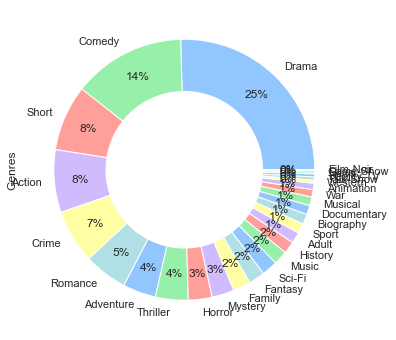

In [153]:
############Reading in dataframe###############
df_title_basics=pd.read_csv(filepath_out_data+"/_Actor_mov_tv_filter_final/part-00000-55d556f3-aa0f-4b28-bee5-009460d57285-c000.csv",sep="|",low_memory=False, na_values=["\\N","nan"])
df_title_basics.Genres.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                                 wedgeprops=dict(width=0.4))


In [154]:
##################Value counts##################
df_title_basics.Genres.value_counts()

Drama          3220789
Comedy         1765647
Short          1032252
Action          984218
Crime           841292
Romance         682775
Adventure       518617
Thriller        514058
Horror          370923
Mystery         350529
Family          277518
Fantasy         253631
Sci-Fi          248915
Music           217961
History         189997
Adult           174001
Sport           157021
Biography       155961
Documentary     144524
Musical         136512
War             114698
Animation        99636
Western          49346
Talk-Show        48977
Reality-TV       46574
News             30099
Game-Show        28925
Film-Noir         6013
Name: Genres, dtype: int64

In [156]:
#df_check=sc.read.csv("C:/Users/91993/Documents/Movies/out/_Actor_mov_tv_filter_final/part-00000-55d556f3-aa0f-4b28-bee5-009460d57285-c000.csv",sep="|",header= True,inferSchema=True)
_Actor_mov_tv_filter_final.show()

+---------+----------+------------------+-----------------+---------+---------+
| Actor_ID|  Title_ID|       primaryName|primaryProfession|titleType|   Genres|
+---------+----------+------------------+-----------------+---------+---------+
|nm0001956| tt0122561|John Wayne Bobbitt|            actor|    video|    Adult|
|nm0001956|tt13634472|John Wayne Bobbitt|            actor|    video|    Adult|
|nm0001956| tt0123610|John Wayne Bobbitt|            actor|    video|    Adult|
|nm0001956| tt0140058|John Wayne Bobbitt|            actor|    video|    Adult|
|nm0001956| tt0122561|John Wayne Bobbitt|            actor|    video|Biography|
|nm0001956|tt13634472|John Wayne Bobbitt|            actor|    video|Biography|
|nm0001956| tt0123610|John Wayne Bobbitt|            actor|    video|Biography|
|nm0001956| tt0140058|John Wayne Bobbitt|            actor|    video|Biography|
|nm0001956| tt0122561|John Wayne Bobbitt|            actor|    video|   Comedy|
|nm0001956|tt13634472|John Wayne Bobbitt

In [157]:
create_temp_table(_Actor_mov_tv_filter_final,"_Actor_mov_tv_filter_final")

In [165]:
########################Genre count for 3 actors####################
check_query=sc.sql("select primaryName,count(Genres) as Genre_count from _Actor_mov_tv_filter_final where primaryName like '%Frances%McDormand%' or primaryName like '%Omar%Sy%' or primaryName like '%Saoirse%Ronan%' group by primaryName,Genres order by primaryName,Genres desc")
check_query.show()

+-----------+-------------+
|primaryName|count(Genres)|
+-----------+-------------+
| Omar Sylla|            1|
+-----------+-------------+



In [158]:
###################Test Case 1: Checking the actor's names in the final dataset###############
check_query1=sc.sql("select * from _Actor_mov_tv_filter_final where primaryName like '%Frances%McDormand%' or primaryName like '%Omar%Sy%' or primaryName like '%Saoirse%Ronan%'")
check_query1.show()

+---------+---------+-----------+-----------------+---------+------+
| Actor_ID| Title_ID|primaryName|primaryProfession|titleType|Genres|
+---------+---------+-----------+-----------------+---------+------+
|nm4826082|tt2151729| Omar Sylla|            actor|    short| Short|
+---------+---------+-----------+-----------------+---------+------+



In [162]:
###################Test Case 2: Checking the actor's names in the Actor_prepared dataset for Question 2###############
check_query2=sc.sql("select * from Actor_data_final where Name like '%Frances%McDormand%' or Name like '%Omar%Sy%' or Name like '%Saoirse%Ronan%'")
check_query2.show()

+---------+---------+------------+----------+
| Actor_ID| Title_ID|        Name|Profession|
+---------+---------+------------+----------+
|nm4826082|tt2151729|  Omar Sylla|     actor|
|nm8849071|tt6648970|Omar Syariff|     actor|
+---------+---------+------------+----------+



In [164]:
###################Test Case 3: Checking the actor's names in the origincal dataset###############
df_check_query3=sc.sql("select * from basic_data where primaryName like '%Frances%McDormand%' or primaryName like '%Omar%Sy%' or primaryName like '%Saoirse%Ronan%'")
df_check_query3.show()

+---------+-----------------+---------+---------+--------------------+--------------------+
|   nconst|      primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+-----------------+---------+---------+--------------------+--------------------+
|nm0000531|Frances McDormand|     1957|       \N|actress,producer,...|tt1748122,tt50277...|
|nm1082477|          Omar Sy|     1978|       \N|actor,writer,prod...|tt1877832,tt16754...|
|nm1519680|    Saoirse Ronan|     1994|       \N|  actress,soundtrack|tt0993842,tt03805...|
|nm4826082|       Omar Sylla|       \N|       \N|               actor|           tt2151729|
|nm8849071|     Omar Syariff|       \N|       \N|               actor|           tt6648970|
+---------+-----------------+---------+---------+--------------------+--------------------+



## Conclusion : 

#### As the question suggests to find the number of genre for which an actor has worked. For this scenario, only actor were considered and not the actress. The question was answered by finding "Omar Sy" as he is an actor where no data was extracted for "Frances McDromand" & "Saoirse Ronan" as those are actresses.